## Density decomposition
Motivation: Need an unambiguous density decomposition stating which density belongs to which atom.

Idea: Use alchemy to grow a molecule from original locations far away.
$$\rho_t = \int_r^t d\lambda \partial_\lambda\rho = \int_r^t d\lambda \sum_I \frac{\partial\rho}{\partial Z_I}\frac{\partial Z_I}{\partial\lambda}=  \sum_I \Delta Z_I\int_r^t d\lambda\frac{\partial\rho}{\partial Z_I}$$

In [15]:
import horton
import numpy as np
import matplotlib.pyplot as plt

## Diatomics

In [106]:
def do_run(refdist, targetdist, pseudo, z1, z2, zsuper, gridpoints):
    print (pseudo)
    mol = horton.IOData(title='test')
    mol.coordinates = np.array([[0.0, 0.0, -refdist/2], [0.0, 0.0, -targetdist/2], [0.0, 0.0, targetdist/2], [0.0, 0.0, refdist/2]]) * horton.angstrom
    mol.numbers = np.array([z1, z1, z2, z2])
    mol.pseudo_numbers = pseudo
    
    basisset = 'STO-6G'
    obasis = horton.get_gobasis(mol.coordinates, mol.numbers, basisset)
    for z in zsuper:
        obasis2 = horton.get_gobasis(mol.coordinates, np.array([z]*4), basisset)
        obasis = obasis.concatenate(obasis2)
    
    olp = obasis.compute_overlap()
    kin = obasis.compute_kinetic()
    na = obasis.compute_nuclear_attraction(mol.coordinates, mol.pseudo_numbers)
    er = obasis.compute_electron_repulsion()
    
    orb_alpha = horton.Orbitals(obasis.nbasis)
    orb_beta = horton.Orbitals(obasis.nbasis)

    # Initial guess
    one = kin + na
    horton.guess_core_hamiltonian(olp, one, orb_alpha, orb_beta)
    
    external = {'nn': horton.compute_nucnuc(mol.coordinates, mol.pseudo_numbers)}
    terms = [
        horton.UTwoIndexTerm(kin, 'kin'),
        horton.UDirectTerm(er, 'hartree'),
        horton.UExchangeTerm(er, 'x_hf'),
        horton.UTwoIndexTerm(na, 'ne'),
    ]
    ham = horton.UEffHam(terms, external)
    
    occ_model = horton.AufbauOccModel(7, 7)
        
    occ_model.assign(orb_alpha, orb_beta)
    dm_alpha = orb_alpha.to_dm()
    dm_beta = orb_beta.to_dm()
    #scf_solver = horton.ODASCFSolver(1e-5, maxiter=400)
    converged = False
    for solver in (horton.EDIIS2SCFSolver, horton.ODASCFSolver, horton.EDIISSCFSolver, horton.CDIISSCFSolver):
        try:
            scf_solver = solver(1e-5, maxiter=400)
            scf_solver(ham, olp, occ_model, dm_alpha, dm_beta)
            converged = True
        except:
            continue
    if not converged:
        raise horton.NoSCFConvergence('no conv')
    
    rho_grid = obasis.compute_grid_density_dm(dm_alpha, gridpoints)
    rho_grid += obasis.compute_grid_density_dm(dm_beta, gridpoints)
    
    return rho_grid

In [107]:
def trace_derivative(refdist, targetdist, z1, z2):
    horton.log.set_level(0)
    # build grid
    xs = np.linspace(-2, 2, 10)*horton.angstrom
    ys = np.linspace(-2, 2, 10)*horton.angstrom
    zs = np.linspace(-refdist/2-2, refdist/2+2, 200)*horton.angstrom
    grid = np.column_stack(map(np.ndarray.ravel, np.meshgrid(xs, ys, zs)))
    
    delta = 0.05
    basepoints = np.linspace(0, 1, 3)
    derivs = [[], [], [], []]
    for lval in basepoints:
        pseudo_base = np.array((z1*(1-lval), z1*lval, z2*lval, z2*(1-lval)))
        
        for atom in (0, 1, 2, 3):
            pseudo = pseudo_base.copy()
            pseudo[atom] += delta/2
            rho_up = do_run(refdist, targetdist, pseudo, z1, z2, [], grid) 
            pseudo[atom] -= delta
            if pseudo[atom] < 0:
                # switch to fwd FD
                rho_dn = do_run(refdist, targetdist, pseudo_base, z1, z2, [], grid)
                deriv = (rho_up-rho_dn)/(delta/2)
            else:
                rho_dn = do_run(refdist, targetdist, pseudo, z1, z2, [], grid)
                deriv = (rho_up-rho_dn)/delta
            derivs[atom].append(deriv)
    
    return grid, zs, basepoints, derivs
grid, zs, basepoints, derivs = trace_derivative(10, 1.5, 7, 7)

[7.025 0.    0.    7.   ]
[6.975 0.    0.    7.   ]
[7.    0.025 0.    7.   ]
[7. 0. 0. 7.]
[7.    0.    0.025 7.   ]
[7. 0. 0. 7.]
[7.    0.    0.    7.025]
[7.    0.    0.    6.975]
[3.525 3.5   3.5   3.5  ]
[3.475 3.5   3.5   3.5  ]
[3.5   3.525 3.5   3.5  ]
[3.5   3.475 3.5   3.5  ]
[3.5   3.5   3.525 3.5  ]
[3.5   3.5   3.475 3.5  ]
[3.5   3.5   3.5   3.525]
[3.5   3.5   3.5   3.475]
[0.025 7.    7.    0.   ]
[0. 7. 7. 0.]
[0.    7.025 7.    0.   ]
[0.    6.975 7.    0.   ]
[0.    7.    7.025 0.   ]
[0.    7.    6.975 0.   ]
[0.    7.    7.    0.025]
[0. 7. 7. 0.]


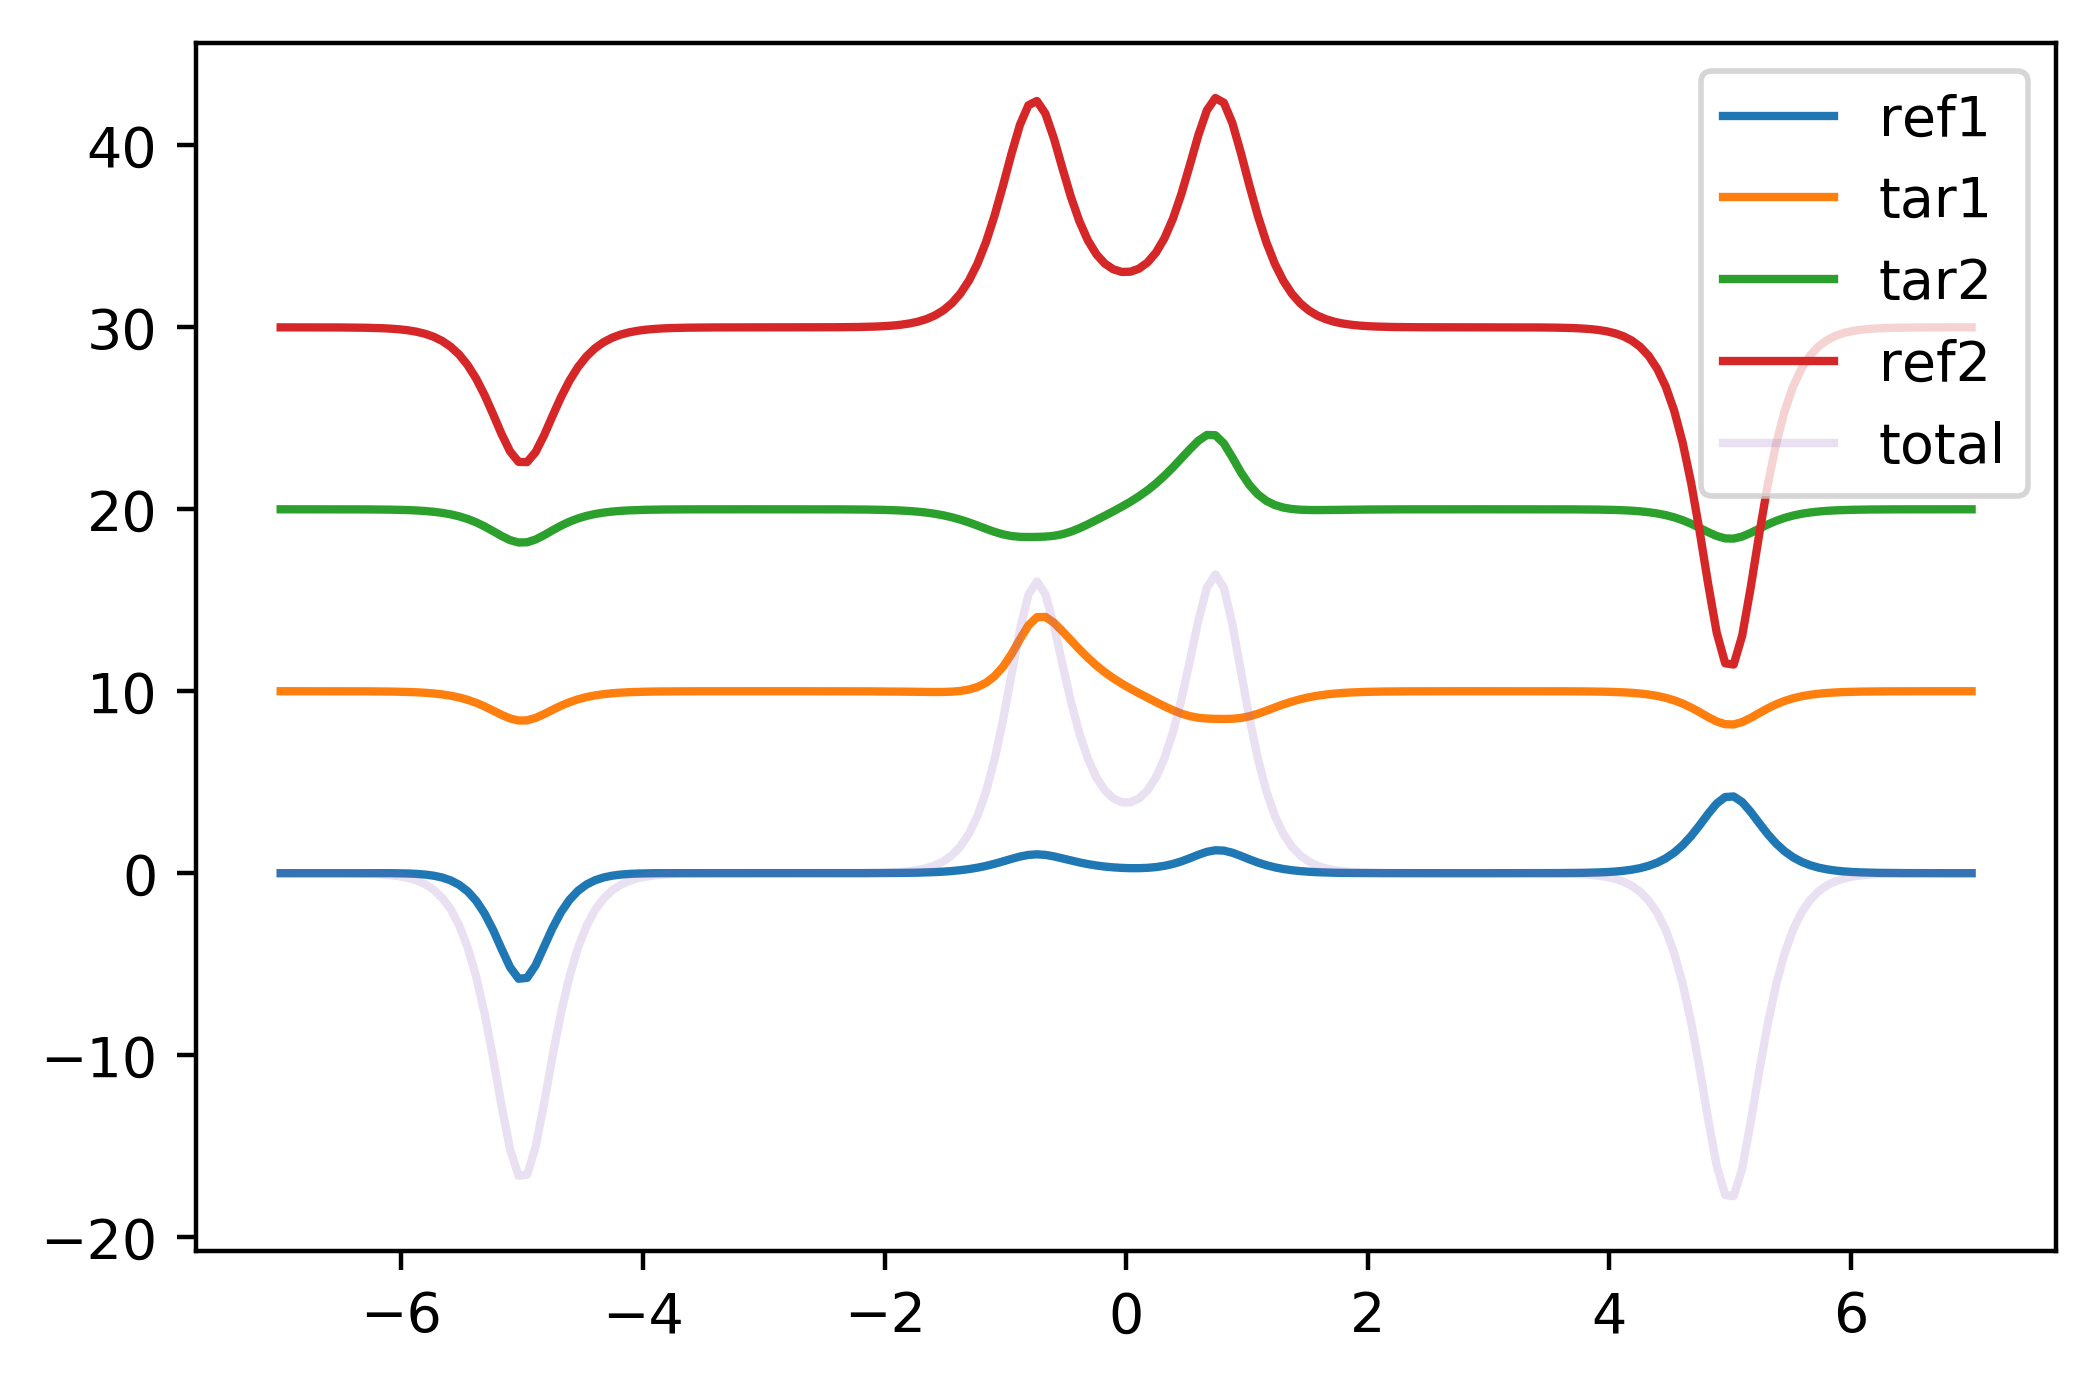

In [109]:
def visualise(grid, zs, basepoints, derivs):
    plt.figure(dpi=400)
    labels = 'ref1 tar1 tar2 ref2'.split()
    deltaZ = (-7, 7, 7, -7)
    total = None
    for atom in range(4):
        rho = np.trapz(np.array(derivs[atom]).T, basepoints, axis=1)
        proj = []
        for zcoord in zs:
            proj.append(np.sum(rho[grid[:, 2] == zcoord]))
        proj = np.array(proj) * deltaZ[atom]
        if total is None:
            total = np.array(proj)
        else:
            total += np.array(proj)
        plt.plot(zs/horton.angstrom, proj+atom*10, label=labels[atom])
    plt.plot(zs/horton.angstrom, total, label='total', alpha=0.2)
    plt.legend()
visualise(grid, zs, basepoints, derivs)